# Data Acquisition - Env Preperation

In [1]:
### Download data from Kaggle ###
### Tutorial Source : https://www.kaggle.com/discussions/general/74235 ###
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d michaeljkerr/20k-album-covers-within-20-genres
import zipfile
import os


zip_file_name = '20k-album-covers-within-20-genres.zip'
extracted_dir = 'dataset'
os.makedirs(extracted_dir, exist_ok=True)
# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f'Dataset extracted to {extracted_dir}')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/michaeljkerr/20k-album-covers-within-20-genres
License(s): unknown
100% 226M/226M [00:12<00:00, 21.3MB/s]
100% 226M/226M [00:12<00:00, 19.7MB/s]
Dataset extracted to dataset


In [16]:
pip install pillow imagehash tensorflow

In [18]:
### Constants ###
RAW_DATASET_DIR="dataset/GAID"
DATASET_DIR="dataset/CLEAN"
TARGET_FORMAT = "JPEG"
TARGET_SIZE = (300,300)
MIN_RESOLUTION = 100
BALANCE_LIMIT = 1000
APPROACH1_MODEL=None
APPROACH2_MODEL=None

# Data Exploring

No issues found.


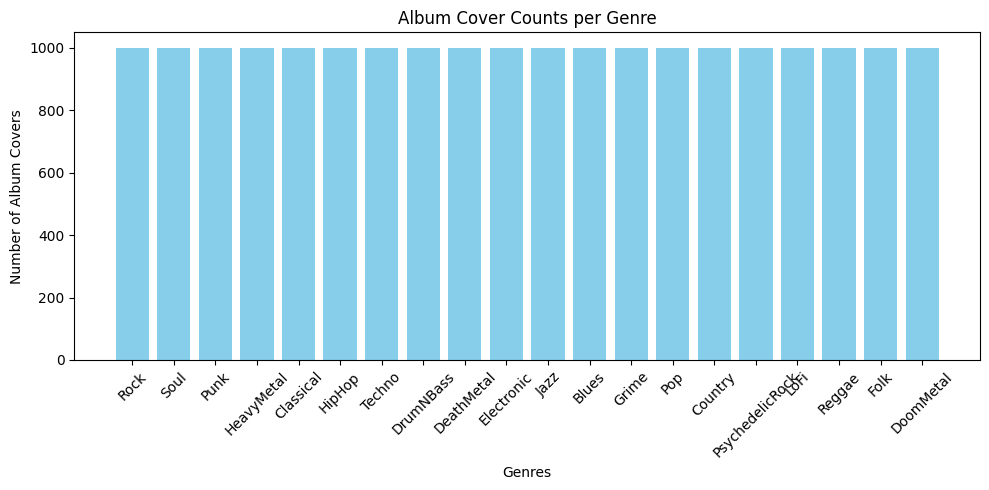

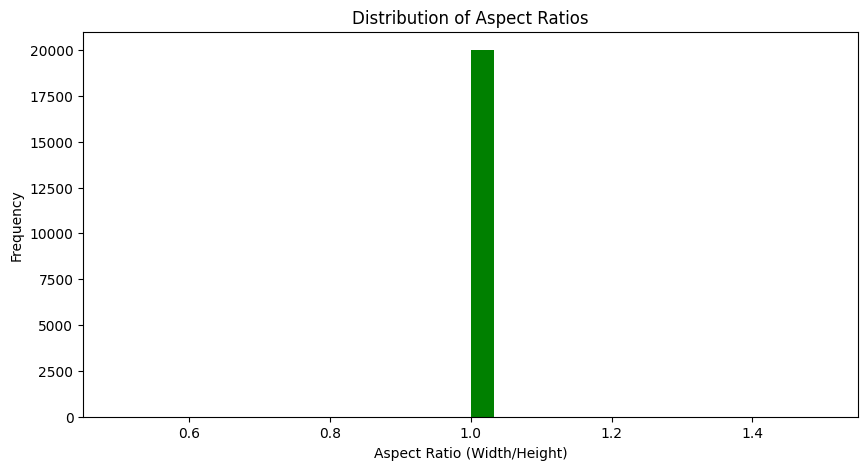

Genre : Rock: [(300, 300)]
Genre : Soul: [(300, 300)]
Genre : Punk: [(300, 300)]
Genre : HeavyMetal: [(300, 300)]
Genre : Classical: [(300, 300)]
Genre : HipHop: [(300, 300)]
Genre : Techno: [(300, 300)]
Genre : DrumNBass: [(300, 300)]
Genre : DeathMetal: [(300, 300)]
Genre : Electronic: [(300, 300)]
Genre : Jazz: [(300, 300)]
Genre : Blues: [(300, 300)]
Genre : Grime: [(300, 300)]
Genre : Pop: [(300, 300)]
Genre : Country: [(300, 300)]
Genre : PsychedelicRock: [(300, 300)]
Genre : LoFi: [(300, 300)]
Genre : Reggae: [(300, 300)]
Genre : Folk: [(300, 300)]
Genre : DoomMetal: [(300, 300)]


In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def explore_folder(root_folder):
    genre_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    issues = {}
    genre_counts = {}
    image_dimensions = {}
    aspect_ratios = {}

    for genre in genre_folders:
        genre_path = os.path.join(root_folder, genre)
        album_files = [f for f in os.listdir(genre_path) if os.path.isfile(os.path.join(genre_path, f))]

        genre_counts[genre] = len(album_files)
        image_dimensions[genre] = []
        aspect_ratios[genre] = []

        for album in album_files:
            album_path = os.path.join(genre_path, album)

            ### Check if file is a valid image ###
            try:
                with Image.open(album_path) as img:
                    img.verify()
                    width, height = img.size
                    image_dimensions[genre].append((width, height))
                    aspect_ratios[genre].append(width / height)
            except (IOError, SyntaxError) as e:
                if genre not in issues:
                    issues[genre] = []
                issues[genre].append(f"Invalid image file: {album}")

    return issues, genre_counts, image_dimensions, aspect_ratios

def visualize_data(genre_counts, image_dimensions, aspect_ratios):
    genres = list(genre_counts.keys())
    counts = list(genre_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(genres, counts, color='skyblue')
    plt.xlabel('Genres')
    plt.ylabel('Number of Album Covers')
    plt.title('Album Cover Counts per Genre')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    ### Plotting aspect ratios ###
    aspect_ratios_flat = [ratio for genre in aspect_ratios.values() for ratio in genre]

    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios_flat, bins=30, color='green')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Aspect Ratios')
    plt.show()

    ### Print unique values of Width/Height ###
    for gen in image_dimensions:
      print(f"Genre : {gen}: {list(set(image_dimensions[gen]))}")

issues, genre_counts, image_dimensions, aspect_ratios = explore_folder(RAW_DATASET_DIR)

if issues:
    for genre, problem in issues.items():
        print(f"Issues in {genre}: {problem}")
else:
    print("No issues found.")

visualize_data(genre_counts, image_dimensions, aspect_ratios)


# Data Cleansing

In [15]:
import os
from PIL import Image
import imagehash
from collections import defaultdict
from shutil import copyfile, rmtree
import random



rmtree(DATASET_DIR, ignore_errors=True)
os.makedirs(DATASET_DIR, exist_ok=True)

def is_low_quality(image, min_res):
    return min(image.size) < min_res

def ensure_format(image, target_format):
    return image.convert("RGB")

def resize_to_aspect(image, target_size):
    return image.resize(target_size)

def remove_duplicates(image_paths):
    hash_dict = defaultdict(list)
    unique_images = []

    for path in image_paths:
        try:
            img = Image.open(path)
            img_hash = imagehash.average_hash(img)
            if img_hash not in hash_dict:
                unique_images.append(path)
            hash_dict[img_hash].append(path)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return unique_images

def balance_dataset(image_paths_by_genre, limit):
    balanced_paths = []
    for genre, paths in image_paths_by_genre.items():
        unique_paths = list(set(paths))  # Remove duplicate paths
        current_set = random.sample(unique_paths, min(len(unique_paths), limit))
        balanced_paths.extend(current_set)
        print(f"{genre} balanced to {len(current_set)} images")
    return balanced_paths

def clean_dataset():
    global BALANCE_LIMIT
    global DATASET_DIR
    global RAW_DATASET_DIR
    genre_dirs = [os.path.join(RAW_DATASET_DIR, d) for d in os.listdir(RAW_DATASET_DIR) if os.path.isdir(os.path.join(RAW_DATASET_DIR, d))]
    image_paths_by_genre = defaultdict(list)

    for genre_dir in genre_dirs:
        genre_name = os.path.basename(genre_dir)

        for file_name in os.listdir(genre_dir):
            file_path = os.path.join(genre_dir, file_name)
            try:
                img = Image.open(file_path)

                # Remove low-quality images
                if is_low_quality(img, MIN_RESOLUTION):
                    print(f"Low quality image removed: {file_path}")
                    continue

                # Ensure format consistency
                img = ensure_format(img, TARGET_FORMAT)

                # Resize to a consistent aspect ratio
                img = resize_to_aspect(img, TARGET_SIZE)

                # Add the image path to the dictionary (no saving yet)
                image_paths_by_genre[genre_name].append(file_path)

            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    for genre, paths in image_paths_by_genre.items():
        unique_paths = remove_duplicates(paths)
        image_paths_by_genre[genre] = unique_paths
        print(f"{len(paths) - len(unique_paths)} duplicates removed from {genre}")
        #Updating BALANCE_LIMIT
        BALANCE_LIMIT = min(BALANCE_LIMIT, len(unique_paths))
        print(f"New BALANCE_LIMIT: {BALANCE_LIMIT}")

    balanced_paths = balance_dataset(image_paths_by_genre, BALANCE_LIMIT)

    #print(f"Balanced paths: {balanced_paths}")

    for path in balanced_paths:
        genre_name = os.path.basename(os.path.dirname(path))  # Extract genre name
        output_genre_dir = os.path.join(DATASET_DIR, genre_name)
        os.makedirs(output_genre_dir, exist_ok=True)

        file_name = os.path.basename(path)
        output_path = os.path.join(output_genre_dir, f"{os.path.splitext(file_name)[0]}.jpg")

        # Ensure the image is saved as JPEG format
        img = Image.open(path)
        img.save(output_path, format=TARGET_FORMAT)

        #print(f"Saved {output_path}")

    print("Dataset cleaning and saving complete!")

### Run the cleaning process ###
clean_dataset()


2 duplicates removed from Rock
New BALANCE_LIMIT: 998
13 duplicates removed from Soul
New BALANCE_LIMIT: 987
9 duplicates removed from Punk
New BALANCE_LIMIT: 987
6 duplicates removed from HeavyMetal
New BALANCE_LIMIT: 987
9 duplicates removed from Classical
New BALANCE_LIMIT: 987
25 duplicates removed from HipHop
New BALANCE_LIMIT: 975
40 duplicates removed from Techno
New BALANCE_LIMIT: 960
23 duplicates removed from DrumNBass
New BALANCE_LIMIT: 960
8 duplicates removed from DeathMetal
New BALANCE_LIMIT: 960
12 duplicates removed from Electronic
New BALANCE_LIMIT: 960
7 duplicates removed from Jazz
New BALANCE_LIMIT: 960
6 duplicates removed from Blues
New BALANCE_LIMIT: 960
79 duplicates removed from Grime
New BALANCE_LIMIT: 921
8 duplicates removed from Pop
New BALANCE_LIMIT: 921
8 duplicates removed from Country
New BALANCE_LIMIT: 921
17 duplicates removed from PsychedelicRock
New BALANCE_LIMIT: 921
54 duplicates removed from LoFi
New BALANCE_LIMIT: 921
12 duplicates removed from 

# Model Training - No Pre-trained model support

In [30]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Get the class (genre) names
classes = os.listdir(DATASET_DIR)

# Initialize lists to hold file paths and labels
file_paths = []
labels = []

# Load file paths and labels
for genre in classes:
    genre_path = os.path.join(DATASET_DIR, genre)
    for img in os.listdir(genre_path):
        file_paths.append(os.path.join(genre_path, img))
        labels.append(genre)

# Encode labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, encoded_labels, test_size=0.2, stratify=encoded_labels)

# Define a function to load and preprocess the images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, TARGET_SIZE)
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Build the model using TensorFlow (Keras)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define ModelCheckpoint callback to save the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.h5', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

# Train the model
APPROACH1_MODEL=model.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=[checkpoint_callback])

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


461/461 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.0558 - loss: 2.9936 - val_accuracy: 0.0752 - val_loss: 2.9692
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.0768 - loss: 2.9678 - val_accuracy: 0.0947 - val_loss: 2.9372
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.0888 - loss: 2.9351 - val_accuracy: 0.1034 - val_loss: 2.9001
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.0969 - loss: 2.9114 - val_accuracy: 0.1067 - val_loss: 2.8843
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.1084 - loss: 2.8883 - val_accuracy: 0.1102 - val_loss: 2.8584
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.1163 - loss: 2.8612 - val_accuracy: 0.1121 - val_loss: 2.8701
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.1253 - loss: 2.8420 - val_accuracy: 0.1224 - val_loss: 2.8480
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.1262 - loss: 2.8292 - val_accurac

# Model Training - MobileNetV2,Data Augmentation And More epochs

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder


classes = os.listdir(DATASET_DIR)
file_paths = []
labels = []

### Append Labels ###
for genre in classes:
    genre_path = os.path.join(DATASET_DIR, genre)
    for img in os.listdir(genre_path):
        file_paths.append(os.path.join(genre_path, img))
        labels.append(genre)

### Encode Labels ###
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

### Data Augmentation ###
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.0],
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

### Build the model using MobileNetV2 ###
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

### Train All Layers ###
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Check Point ###
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.MNV2.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

APPROACH2_MODEL=model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Found 14740 images belonging to 20 classes.
Found 3680 images belonging to 20 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


461/461 ━━━━━━━━━━━━━━━━━━━━ 261s 487ms/step - accuracy: 0.1224 - loss: 2.8949 - val_accuracy: 0.1524 - val_loss: 3.0658
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 211s 453ms/step - accuracy: 0.2085 - loss: 2.5810 - val_accuracy: 0.1734 - val_loss: 2.8269
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 211s 451ms/step - accuracy: 0.2441 - loss: 2.4622 - val_accuracy: 0.1992 - val_loss: 2.6663
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 208s 446ms/step - accuracy: 0.2767 - loss: 2.3504 - val_accuracy: 0.1973 - val_loss: 2.7038
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 211s 451ms/step - accuracy: 0.2989 - loss: 2.2829 - val_accuracy: 0.2177 - val_loss: 2.7372
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 212s 453ms/step - accuracy: 0.3316 - loss: 2.1848 - val_accuracy: 0.2174 - val_loss: 2.6889
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 210s 450ms/step - accuracy: 0.3578 - loss: 2.0910 - val_accuracy: 0.1978 - val_loss: 2.8761
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 212s 453ms/step - accuracy: 0.3836 - loss: 2.00

# Results Insights

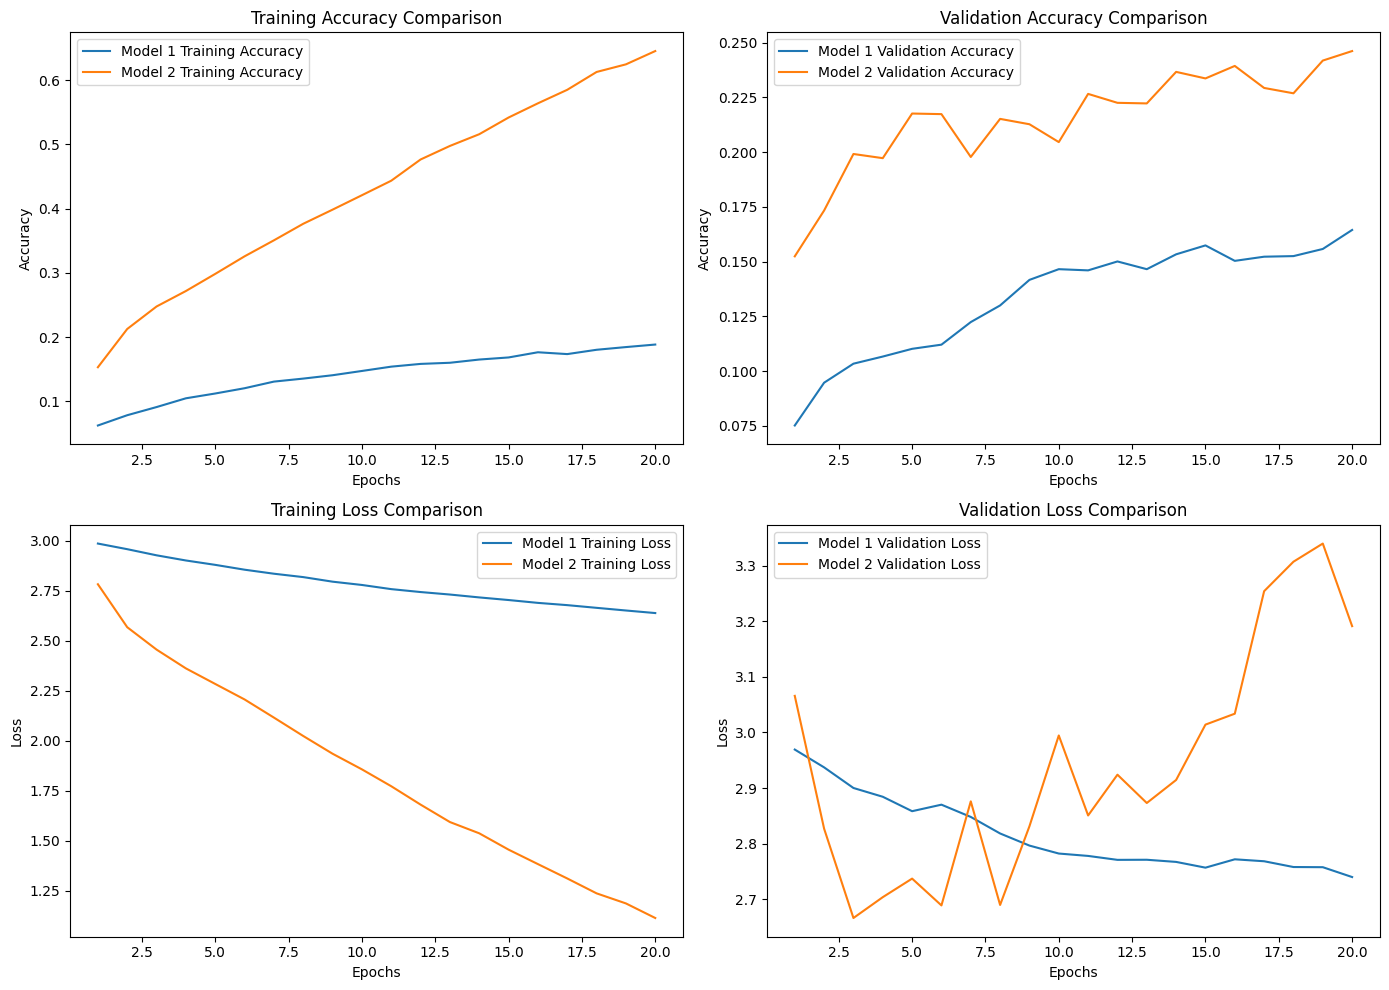

In [31]:
import matplotlib.pyplot as plt

### Extracting metrics from the first model's history ###
train_accuracy_1 = APPROACH1_MODEL.history['accuracy']
val_accuracy_1 = APPROACH1_MODEL.history['val_accuracy']
train_loss_1 = APPROACH1_MODEL.history['loss']
val_loss_1 = APPROACH1_MODEL.history['val_loss']

### Extracting metrics from the second model's history ###
train_accuracy_2 = APPROACH2_MODEL.history['accuracy']
val_accuracy_2 = APPROACH2_MODEL.history['val_accuracy']
train_loss_2 = APPROACH2_MODEL.history['loss']
val_loss_2 = APPROACH2_MODEL.history['val_loss']

### Plotting the results ###
epochs_1 = range(1, len(train_accuracy_1) + 1)
epochs_2 = range(1, len(train_accuracy_2) + 1)

plt.figure(figsize=(14, 10))

# Plotting training accuracy for both models
plt.subplot(2, 2, 1)
plt.plot(epochs_1, train_accuracy_1, label='Model 1 Training Accuracy')
plt.plot(epochs_2, train_accuracy_2, label='Model 2 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

# Plotting validation accuracy for both models
plt.subplot(2, 2, 2)
plt.plot(epochs_1, val_accuracy_1, label='Model 1 Validation Accuracy')
plt.plot(epochs_2, val_accuracy_2, label='Model 2 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

# Plotting training loss for both models
plt.subplot(2, 2, 3)
plt.plot(epochs_1, train_loss_1, label='Model 1 Training Loss')
plt.plot(epochs_2, train_loss_2, label='Model 2 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Plotting validation loss for both models
plt.subplot(2, 2, 4)
plt.plot(epochs_1, val_loss_1, label='Model 1 Validation Loss')
plt.plot(epochs_2, val_loss_2, label='Model 2 Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

**Model 2** is more effective during training and reaches higher accuracy faster. However, its validation performance shows instability, suggesting potential overfitting.

**Model 1** learns more slowly but demonstrates more stable validation performance, which might make it more reliable for unseen data.


# Approach 2 with early stopping , prevent overfitting and increase epochs

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

### Modify Data Augmentation ###
datagen = ImageDataGenerator(
    validation_split=0.2  # No augmentation; just splitting data
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

### Increase Model Complexity ###
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increase number of neurons
x = Dense(256, activation='relu')(x)  # Add another dense layer
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

### Train All Layers ###
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Add Early Stopping ###
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,                # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore model weights from the best epoch
)

APPROACH3_MODEL = model.fit(
    train_generator,
    epochs=50,  # High epoch count to demonstrate early stopping
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Include EarlyStopping callback
    verbose=1
)

loss, accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Found 14740 images belonging to 20 classes.
Found 3680 images belonging to 20 classes.
Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 104s 150ms/step - accuracy: 0.4151 - loss: 1.9540 - val_accuracy: 0.2497 - val_loss: 2.9019
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.7442 - loss: 0.8050 - val_accuracy: 0.2652 - val_loss: 3.2356
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.8422 - loss: 0.5119 - val_accuracy: 0.2337 - val_loss: 3.9823
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.8830 - loss: 0.3878 - val_accuracy: 0.2595 - val_loss: 3.9522
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.9048 - loss: 0.3206 - val_accuracy: 0.2620 - val_loss: 4.5428
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.9176 - loss: 0.2774 - val_accuracy: 0.2663 - val_loss: 4.7594
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.9201 - loss: 0.2661 - val_accuracy: 0.2674 - val_loss: 4.